In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("/home/pdas/workspace/data/names.txt") as f:
    words = f.read().splitlines()

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s : i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

In [7]:
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix1 = stoi[ch]
        X.append(context)
        Y.append(ix1)
        print("".join([itos[i] for i in context]), '----->', itos[ix1])
        context = context[1:] + [ix1]

yuheng
... -----> y
..y -----> u
.yu -----> h
yuh -----> e
uhe -----> n
hen -----> g
eng -----> .
diondre
... -----> d
..d -----> i
.di -----> o
dio -----> n
ion -----> d
ond -----> r
ndr -----> e
dre -----> .
xavien
... -----> x
..x -----> a
.xa -----> v
xav -----> i
avi -----> e
vie -----> n
ien -----> .
jori
... -----> j
..j -----> o
.jo -----> r
jor -----> i
ori -----> .
juanluis
... -----> j
..j -----> u
.ju -----> a
jua -----> n
uan -----> l
anl -----> u
nlu -----> i
lui -----> s
uis -----> .


In [6]:
C = torch.randn((27,2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [8]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [17]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2

counts = logits.exp()
probs = counts / counts.sum(axis =1, keepdims = True)

loss = -probs[torch.arange(0, X.size(0)), Y].log().mean()
loss

tensor(17.8558)

In [18]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [62]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [63]:
sum([p.nelement() for p in parameters]) # num of parameters

11897

In [64]:
for p in parameters:
    p.requires_grad = True

In [47]:
tr_loss = []

In [48]:
for epoch in range(100):
    lb = 0
    epoch_loss = 0.0
    while lb < Xtr.shape[0]:
        ix = torch.arange(lb, lb+30)
        emb = C[Xtr[ix]]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        epoch_loss += loss.item()

        for p in parameters:
            p.grad = None
        loss.backward()
        
        lr = 0.1 if epoch < 50 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        lb += 30
    tr_loss.append(epoch_loss)
    print(f"Epoch : [{epoch+1}/50] Loss : {epoch_loss: .4f}")

Epoch : [1/50] Loss :  20932.6648
Epoch : [2/50] Loss :  15799.5622
Epoch : [3/50] Loss :  15312.0021
Epoch : [4/50] Loss :  15034.8897
Epoch : [5/50] Loss :  14853.3158
Epoch : [6/50] Loss :  14719.4560
Epoch : [7/50] Loss :  14612.8258
Epoch : [8/50] Loss :  14524.2992
Epoch : [9/50] Loss :  14449.2451
Epoch : [10/50] Loss :  14384.9401
Epoch : [11/50] Loss :  14328.9657
Epoch : [12/50] Loss :  14279.5699
Epoch : [13/50] Loss :  14235.6036
Epoch : [14/50] Loss :  14196.2579
Epoch : [15/50] Loss :  14160.6542
Epoch : [16/50] Loss :  14128.0171
Epoch : [17/50] Loss :  14097.9751
Epoch : [18/50] Loss :  14070.2982
Epoch : [19/50] Loss :  14044.6634
Epoch : [20/50] Loss :  14020.7815
Epoch : [21/50] Loss :  13998.3788
Epoch : [22/50] Loss :  13977.2648
Epoch : [23/50] Loss :  13957.3542
Epoch : [24/50] Loss :  13938.6145
Epoch : [25/50] Loss :  13920.9808
Epoch : [26/50] Loss :  13904.3408
Epoch : [27/50] Loss :  13888.5575
Epoch : [28/50] Loss :  13873.4981
Epoch : [29/50] Loss :  13859

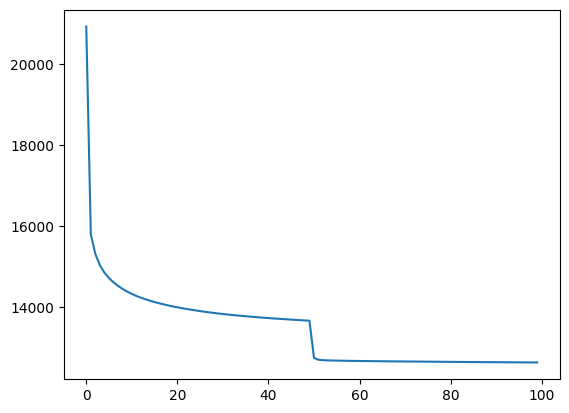

In [49]:
stepi = np.arange(100)
plt.plot(stepi, tr_loss)

In [50]:
emb = C[Xtr] # (182625, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (182625, 100)
logits = h @ W2 + b2 # (182625, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0728, grad_fn=<NllLossBackward0>)

In [51]:
emb = C[Xdev] # (22655, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (22655, 100)
logits = h @ W2 + b2 # (22655, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1324, grad_fn=<NllLossBackward0>)

In [52]:
emb = C[Xte] # (22655, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (22655, 100)
logits = h @ W2 + b2 # (22655, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1498, grad_fn=<NllLossBackward0>)

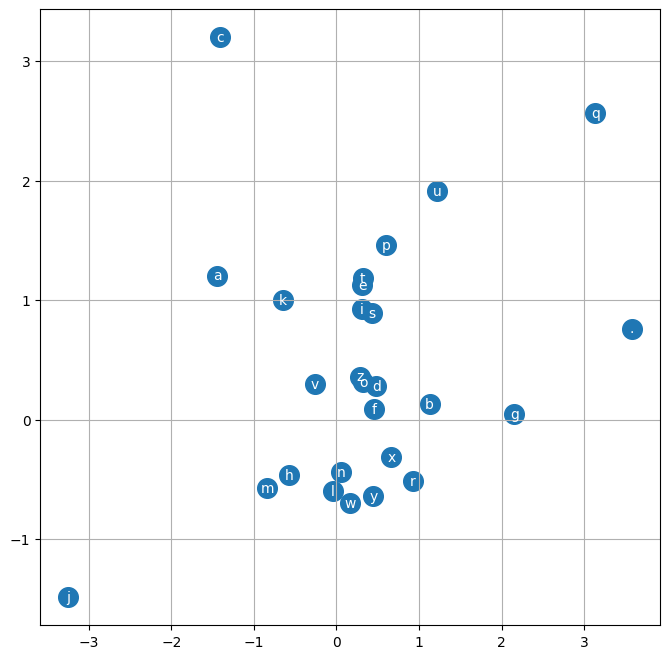

In [53]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [54]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      if ix == 0:
        break
      out.append(ix)
    print(''.join(itos[i] for i in out))

celia
moulius
ilah
tyha
malimitta
nolandrika
aa
samiyah
javariio
amiiz
amelah
jacobeda
kaley
masidgu
akavion
ratls
malynn
avtahlas
kashra
antil


In [56]:
# lr search
lrs = torch.linspace(-3, 0, 1000)
lre = 10**lrs

In [65]:
stepi = []
lri = []
lossi = []

for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lre[i]
#   lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

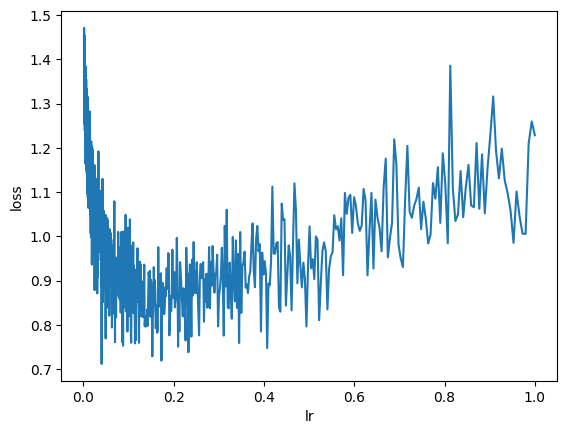

In [67]:
# The right choice for lr lies in the valey
plt.plot(lri, lossi)
plt.xlabel("lr")
plt.ylabel("loss")
plt.show()